In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble        import RandomForestClassifier
from sklearn.metrics         import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

df = pd.read_csv("../batch/data/sensors.csv", parse_dates=["event_time"])
df.head()

,event_time,machine_id,temperature,vibration,rpm
0,2025-06-20 19:31:43.041320,M-001,63.06,0.063,1725
1,2025-06-20 19:31:43.082343,M-002,77.72,0.233,2018
2,2025-06-20 19:31:43.125830,M-002,60.48,0.201,1693
3,2025-06-20 19:31:43.162174,M-004,77.05,0.089,2092
4,2025-06-20 19:31:43.193086,M-001,80.47,0.092,2038


In [2]:
TH = 85
df["is_hot"] = (df["temperature"] > TH).astype(int)

df["hour"] = df["event_time"].dt.hour
df["minute"] = df["event_time"].dt.minute
df["second"] = df["event_time"].dt.second

features = ["temperature", "vibration", "rpm", "hour", "minute", "second"]
X = df[features]
y = df["is_hot"]

print(X.shape, y.value_counts())

(499, 6) is_hot
0    410
1     89
Name: count, dtype: int64


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (399, 6) Test: (100, 6)


In [4]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, rf.predict_proba(X_test)[:,1]))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        18

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

ROC AUC: 1.0


In [5]:
param_grid = {
      "n_estimators": [50, 100],
      "max_depth": [5, 10, None]
}
gs = GridSearchCV(rf, param_grid, cv=3, scoring="roc_auc", n_jobs=-1)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
best = gs.best_estimator_

y_pred = best.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, best.predict_proba(X_test)[:,1]))

Best params: {'max_depth': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        18

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

ROC AUC: 1.0


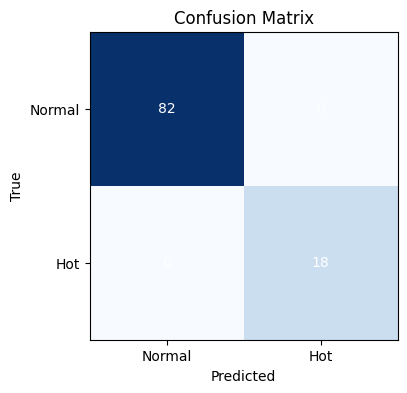

In [6]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xticks([0,1], ["Normal","Hot"])
plt.yticks([0,1], ["Normal","Hot"])
for i in range(2):
      for j in range(2):
            plt.text(j, i, cm[i,j], ha="center", va="center", color="white")
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

In [7]:
import joblib, os
out_path = os.path.abspath("../serving/model_rf.pkl")
joblib.dump(best, out_path)

['c:\\Users\\matie\\Desktop\\Projects\\ServoSense\\serving\\model_rf.pkl']